# EEG-ERP Preprocessing
---
## Learning Objectives
- Be able to describe the standard steps in preprocessing EEG data for ERP analysis, including filtering, visual inspection, automated artifact detection and removal using independent components analysis, bad channel removal and interpolation, re-referencing, and averaging
- Be able to describe the motivation for each of these preprocessing steps
- Be able to perform each preprocessing step using MNE

---

## Introduction
**Preprocessing** is a series of signal processing steps that are performed on data prior to analysis (EDA and/or statistical analysis) and interpretation. In virtually all forms of neuroimaging data, including EEG and MEG, preprocessing is necessary in order to remove noise and obtain a clean signal of interest. In the case of EEG, the data recorded from the scalp are inevitably a mixture of signals generated from the brain (which we likely care about), and other signals generated by sources other than the brain (which we generally don't wish to interpret). 

When they first learn about preprocessing, some people think it sounds a lot like cheating — "doctoring" or "cooking" the data to engineer a specific pattern of desired results. This is *not* the case, however. Preprocessing steps are carefully designed and implemented based on our understanding of the source and nature of particular sources of noise, as well as our understanding about the nature of the electrical activity generated by the brain. Because the skull is such a poor conductor of electricity, the amplitude of EEG signals recorded from the scalp is very small. In contrast, the amplitude of signals from noise sources — especially from the muscles and eyes — are often an order of magnitude or more larger. Thus if we fail to remove these known sources of noise from the data, it would be unlikely that we would detect the brain activity at all, and at best our ability to do so and make valid interpretations would be greatly diminished. In other words, ***preprocessing is an essential step in EEG analysis***.

In this lesson we will describe each standard step in preprocessing EEG data for ERP analysis, including why it is done, and how, using the MNE package. A script that runs a series of preprocessing steps on data is often called a **piepline**; often this term is used to also include the entire proces from transferring data from the EEG system to a server or other long-term storage, preprocessing, and statistical analysis. The present script is an example of a **preprocessing pieline**.

### Sources of noise in EEG

In EEG, sources of noise can be physiological and non-physiological.

**Physiological** sources of noise include muscles (especially face and neck muscles, which generate electrical potentials when contracting and relaxing), the eyes (which create distinctive signals both during blinks, and when the eyeballs move), and sometimes heartbeats (the heart produces strong, distinctive electrical signals as commonly measured with the electrocardiogram, or EKG) and breathing; the latter two sources typically are more of a problem for MEG than EEG data.

**Non-physiological** sources include artifacts generated when electrodes move relative to the scalp, when the electrode wires move, and ambient electromagnetic noise. Electromagnetic noise is created by virtually any device that uses electricity (except some battery-powered devices). In North America and some other parts of the world, **line voltage** — the alternating current that is provided through wired electrical outlets — oscillates at 60 Hz; in Europe and other parts of the world, line voltage alternates at 50 Hz. Thus depending on where the EEG data were recorded, they will likely contain a fairly distinct peak in the frequency spectrum at 50 or 60 Hz. While line noise is the most common source of electromagnetic interference, noise at other frequencies can also be produced by other equipment near the neuroimaging system (though sometimes this may be in another room or another floor of the building, and difficult to identify), or even stronger, transient sources (such as the 2-way radio of a passing truck).




---

## Load packages

In [1]:
import mne
mne.set_log_level('error')

import numpy as np
import matplotlib.pyplot as plt
import glob

# from mne.viz.ica import _prepare_data_ica_properties
# from scipy.stats import zscore
# from autoreject import Ransac, get_rejection_threshold, AutoReject
# import os

## Define experimental and preprocessing parameters

In the single unit chapter, we started the practice of defining experimental parameters as variables at the top of a notebook. This is good practice because the values are then defined when you need them. As well, it's good practice to define all of these parameters at the top of the file, rather than in the cell where you first need to use them. This is because, if later you want to change a parameter and re-run your notebook, it's easy to find all of the parameters, rather than scrolling through the script to find them. As well, when you report your results (e.g., in the Methods section of a paper), many of these parameters are things that you should include in your report. Defining them all at the top of a script makes it easy to find these values when you're writing up your study. 

<div class="alert alert-block alert-info">
<h3>Best practices in EEG/MEG reporting</h3>
    
Especially for people who are new to any field of neuroimaging, there can be an overwhelming array of technical information relating to how the data were collected, preprocessed, and analyzed. This can make it challenging to know how, or what, to report. Fortunately, leaders in the field have reached a general consensus on this, and have published guidelines for reporting EEG and MEG study results. The most recent of these is from [Pernet and colleagues (2020)](https://www.nature.com/articles/s41593-020-00709-0) and is endorsed by the Organization for Human Brain Mapping.    
    
</div> 

Below we define all the parameters we'll use in this preprocessing script. We'll explain them in more detail as we reach each step in the preprocessing pipeline.

In [3]:
# Participant ID code
p_id = 'P4'

# Electrode position file
montage = 'standard_1005'

# Filter settings
low_cut = 0.1
hi_cut  = 30
l_trans_bandwidth = 'auto'
h_trans_bandwidth = 'auto'
filter_length='auto'
filter_method = 'fir'

# ICA settings
ica_low_cut = 1.0       # For ICA, we filter out more low-frequency power
ica_random_state = 42   # ensures ICA is reproducable each time it's run
n_components = .995     # Specify n_components as a decimal to set % explained variance
ica_zthresh = 3.291     # USed to automatically determine which ICA components to reject 

# Event codes
event_id = {'video1':1, 'video2':2,
            'video3':3, 'video4':4,
            'video5':5, 'video6':6,
            'rest_start':7, 'rest':8,
           }

# Epoching settings
tmin = -1.0  # start of each epoch (in sec)
tmax =  1.0  # end of each epoch (in sec)
baseline = None  #(None, 0)
detrend = 0
reject = None
flat = None

## Import raw data

This is just the same as in the previous lesson

In [6]:
raw_file = 'data/' + p_id + '.vhdr'

raw = mne.io.read_raw_brainvision(raw_file, preload=True)

## Set electrode positions

In [7]:
raw.set_montage(montage)

<RawBrainVision | P4.eeg, 16 x 682590 (1365.2 s), ~83.4 MB, data loaded>

## Filtering

As described in the previous section on [Time and Frequency Domains](./time_freq), a complex time-varying signal like EEG can be represented as a combination of sine waves of many different frequencies. Human EEG largely comprises signal power in a range of frequencies from 1–30 Hz; there is some evidence that higher frequencies may also carry important neurophysiological information, however in most EEG studies — and certainly in ERP studies — the vast majority of research questions concerns EEG signals in the 1–30 Hz frequency range. 

Sources of noise also manifest as oscillating frequencies that are picked up by EEG. In particular, *low frequency noise* comes from sources such as movement of the head and electrode wires, and perspiration on the scalp, while *high frequency noise* comes from sources including electromagnetic interference, and muscle contractions (especially facial and neck muscles). The frequency of these sources of noise may overlap with the 1-30 Hz EEG nad of interest, but in general they tend to be lower and higher, respectively, than human EEG. This means that by reducing the power of the signal at the frequencies above and below the range of experimental interest, we can reduce noise with minimal impact on the signals of interest. This process is called **filtering**.

Filtering typically occurs at two points in the EEG pipeline: first at the time the data are recorded, and secondly during preprocessing. When EEG data are collected, the EEG amplifier will at the very least have a filter that cuts off frequencies that are higher than a certain threshold. This is called the **low pass filter cutoff**, because the filter "passes" lower frequencies through, but attenuates (reduces) higher frequencies. A low pass filter is absolutely *necessary* during digital recording of EEG (or any signal), because of a phenomenon known as **aliasing**. This occurs when a high-frequency signal is sampled at a rate lower than the frequency of the signal, and the result is an artifact (an artificial signal that distorts our true signal) at a much lower frequency than the actual high-frequency source. 

### Aliasing

Simply knowing that aliasing causes high-frequency noise to be represented in the data as low-frequency artifacts — and that for this reason it's important to use a low-pass filter — is the most critical thing for someone doing EEG research. However, it's good to understand this phenomenon a little deeper. 

For example, in the current data set the EEG was recorded with a sampling rate of 500 Hz, meaning we obtained a measurement from each electrode every 2 ms. This is a sufficient sampling rate to detect an EEG signal at 30 Hz, because over the course of each cycle of the 30 Hz oscillation (e.g., from one peak to the next), which would last 1/30th of a second, we would have 500 / 30  $\approx$ 17 measurements of the waveform — so we should have enough samples to accurately reflect the shape of the oscillating sine wave. 

In contrast, imagine that during the recording, there was an electromagnetic (noise) signal present in the environment that oscillated at 1700 Hz. Thus in 1 second, the noise signal would have 1700 oscillations, but our EEG amplifier could not detect this, since it is only sampling 500 times per second. In fact, 3.4 oscillations of the noise waveform would occur between every sample acquired by the EEG amplifier. Since 1700 is not an even multiple of 500, each sample acquired by our EEG amplifier would also capture a different phase of the 17000 Hz oscillation — sometimes its peak, sometimes its trough, and sometimes somewhere in between. When we "connect the dots" between these samples to draw our measured EEG signal, these measurements at different points in the oscillation will end up looking like a much lower-frequency oscillation. **This is shown in the figure below.**

![aliasing figure]()

The highest frequency that one can accurately record at a given sampling rate is called the **Nyquist frequency**. This can be defined as either 1/2 or 1/3 of the sampling rate. In general, you should use 1/3 because it is safest. Using 1/2 is acceptable only if you can guarantee that your noise sources and your signal are *phase locked*, meaning (in a simplified way) that their peaks and troughs are synchronized with each other. Since we can't guarantee this in real-world situations where noise is unpredictable, the 1/3 rule should be used.

### Offline filtering

**Offline** is a term that is generally used in EEG to refer to processing steps that are applied after the data are collected, in contrast to **online** processing that is applied when data are collected. So, the low-pass filter used during recording to prevent aliasing is an example of an online filter, while filtering that we apply in a script like this is offline filtering. 

Offline filtering serves to remove more noise from the data than online filtering. In general, EEG researchers prefer to record with a wider range of filter settings, in part because filters can cause distortions to the data, particularly if the cutoffs are too close to the range of frequencies of interest. Any online filter that is applied to the data is permanent, since the data are originally recorded that way — there is no "undo" option. In contrast, with offline filtering one can apply different filters and observe the results on the data, and re-load the original data and use different filter settings if necessary. 

### Offline filter settings

We defined our filter cutoffs in the parameters section above, and the settings used are pretty standard in the world of ERP analysis: a high-pass (low frequency) cutoff of 0.1 Hz, and a low-pass (high frequency) cutoff of 30 Hz (some researchers use 40 Hz instead). Together, this is called a **band pass filter**, because we preseve a "band" of frequencies between teh high-pass and low-pass cutoffs. 

These settings strike an optimal balance between attenuating artifacts outside the range of human EEG signals of interest, without inducing artifacts of their own. These artifacts typically occur if the filter cutoffs are too close to the range of frequencies of scientific interest. It turns ou that the high-pass cutoff needs to be much lower (by a factor of about 10) than the lowest frequency of interest (hence 0.1 when our lowest frequency of interest is 1 Hz), while the low-pass cutoff can be much closer to the highest frequency of interest (in most ERP research, components of interest are rarely higher than about 10 Hz).

### Always filter first

Filtering should always be one of the first preprocessing steps you apply to your data. Most importantly, filtering should be applied to the continuous, raw EEG data before it is chopped into short segments time-locked to the event codes of interest. This is because we need long segments of data in order to accurately estimate and remove low frequencies. For example, our low frequency cutoff of 0.1 Hz corresponds to one sine wave oscillation every 10 sec, and we would need 20-30 s of data to estimate this accurately. A typical segment of data for ERP analysis is only about 1-2 s long at most, and so once your data are segmented, you can't remove low frequencies. Even for high frequencies, filtering results in removing the first and last few data points from the data (for technical reasons we won't cover here), and so again it's better to filter at the start and not worry about it later.

MNE provides a `.filter()` method for `Raw` data that is simple to apply, but is actually very powerful because of the many options provided. If you're interested in more detailed discussion of how filtering works, both in general and in MNE, their website has a very detailed [discussion of filtering](https://mne.tools/stable/auto_tutorials/preprocessing/25_background_filtering.html).

### Plot the frequency spectrum of the raw data

MNE's `.plot_psd()` method plots the **power spectral density** (PSD) of a data set. *Power* refers to the amplitude of sine waves when we are working in the frequency domain, *spectrum* means a range of frequencies, and *density* basically means we're quantifying the power over a range of frequencies. In a sense, you can think of a PSD as a histogram of frequency information — frequency is a continuous variable that is divided into bins (bin size is determined automatically), and the amount of power is plotted for each frequency bin. 

MNE automatically colour-codes electrodes based on their position on the scalp, as shown in the inset to the figure, and the lines in the PSD represent the data from each corresponding electrode. 

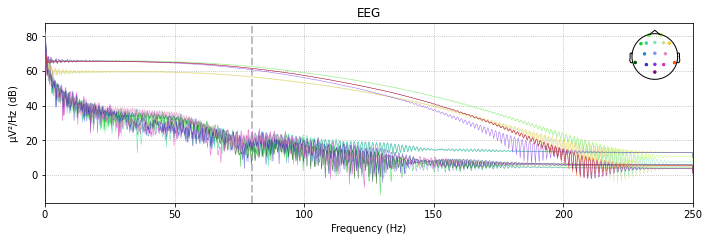

In [12]:
raw.plot_psd();

The PSD above shows a typical property of human EEG (and many other kinds frequency spectra), known as the **1 / *f*** property. That is, power is highest at the lowest frequencies, and drops off with increasing frequency. 

The dashed line shows the low-pass cutoff that was used during data acquisition. This information was stored in the EEG header file, and read by MNE when the data was imported.

### Filter the raw data

We need to chain the `.copy()` and `.filter()` methods because by default, the `.filter()` method modifies the raw data in-place, rather than creating a new, filtered copy of the data. This is sensible for managing the memory used, but can create problems if we want to change the filter settings and redo the filtering step. 

All of the parameters used for filtering were defined at the top of this notebook.

In [13]:
raw_filt = raw.copy().filter(low_cut, hi_cut,
                             l_trans_bandwidth = l_trans_bandwidth,
                             h_trans_bandwidth = h_trans_bandwidth,
                             filter_length=filter_length,
                             method=filter_method)

### Plot the frequency spectrum of the filtered data

We add the `fmax` kwarg to cut off the *x* axis at 100 Hz, since frequencies above this are of no interest. 

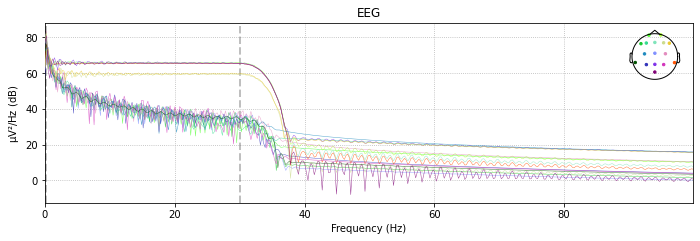

In [15]:
raw_filt.plot_psd(fmax=100);

The effects of our low-pass filter are quite evident — in comparison to the pre-filtering PSD, there is a dramatic drop in power above our 30 Hz cutoff (note that the dashed line has moved to reflect our new low-pass cutoff). 

The effects of the high-pass filtering are much harder to see, since the scale is linear from 0–100 Hz, but our cutoff of 0.1 Hz was very close to zero. If we set `fmax` to 10 we can see the effects of the high-pass cutoff more clearly:

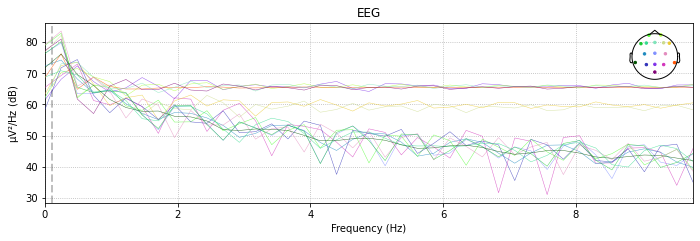

In [18]:
raw_filt.plot_psd(fmax=10);

Note that for both the high- and low-pass filters, the power does not drop of sharply right at the cutoff frequency we specified. Rather, there is a **roll-off** — a range of frequencies over which the power gradually decreases. The shape of the roll-off is a property of the filter that is determined by its parameters, and some roll-off is a necessary feature of any filter if aftifacts are to be avoided. Again, this is a deep topic that we won't delve into here, but in general it is useful to remember the adage that *precision in the frequency domain is inversely related to precision in the time domain*. In other words, if we use a sharper frequency cutoff, we are likely to induce larger artifacts in the data, when we view the filtered data in the time domain. 

### Visualizing the effects of filtering in the time domain